In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [140]:
import pickle as pkl
from PixelEM import *
def greedy(sample,objid,algo,est_type=""):
    tiles = pkl.load(open("../analysis/pixel_em/{}/obj{}/tiles.pkl".format(sample,objid)))
    gt = get_gt_mask(objid)
    if est_type=="ground_truth":
        #using ground truth ia for testing purposes
        gt_idxs = set(zip(*np.where(gt)))
    else:
        log_probability_in_mask=pkl.load(open("../analysis/pixel_em/{}/obj{}/{}_p_in_mask_ground_truth.pkl".format(sample,objid,algo)))
        log_probability_not_in_mask =pkl.load(open("../analysis/pixel_em/{}/obj{}/{}_p_not_in_ground_truth.pkl".format(sample,objid,algo)))
    candidate_tiles_lst = []
    metric_lst = []
    ia_lst = []
    picked_tiles = []
    GT_area  = 0. #sum of intersection areas of all tiles
    total_intersection_area = 0. 
    total_outside_area = 0. 

    # compute I/O metric for all tiles
    #for tile in tiles[1:]:#ignore the large outside tile
    for tile in tiles[1:]:
        if est_type=="ground_truth":
            intersection_area = float(len(gt_idxs.intersection(set(tile)))) # exact intersection areas
        else:
            pInT = np.exp(log_probability_in_mask[list(tile)[0]]) # all pixels in same tile should have the same pInT
            pNotInT = np.exp(log_probability_not_in_mask[list(tile)[0]])
            if pInT+pNotInT!=0:
                norm_pInT = pInT/(pNotInT+pInT) #normalized pInT
            else: #weird bug for object 18 isoGT case
                norm_pInT = 1.
            assert norm_pInT<=1 and norm_pInT>=0
            intersection_area = float(len(tile) * norm_pInT) #estimated intersection area
        outside_area = float(len(tile) - intersection_area)
        GT_area+= intersection_area
        if outside_area!=0:
            metric = intersection_area/outside_area
            metric_lst.append(metric)
            candidate_tiles_lst.append(tile)
            ia_lst.append(intersection_area)
        else:# if outside area =0, then tile completely encapsulated by GT, it must be included in picked tiles
            #print "here"
            picked_tiles.append(tile)
            total_intersection_area += intersection_area
            total_outside_area += outside_area

    assert len(metric_lst)==len(candidate_tiles_lst)==len(ia_lst)
    srt_decr_idx = np.argsort(metric_lst)[::-1] # sorting from largest to smallest metric_lst
    #print np.array(metric_lst)[srt_decr_idx]
    jaccard_lst = []
#     if total_area!=0:
#         print "here"
#         prev_jac = ia_cum / total_area
#     else:
#         prev_jac = -10000.
    prev_jacc = total_intersection_area/(total_outside_area+GT_area)
#     prev_jac = -10000.
#    print ia_cum,total_area
#    print prev_jac
    for tidx  in srt_decr_idx:
        tile = candidate_tiles_lst[tidx]
        ia = ia_lst[tidx]
        if ia!=0:
            temp_new_out_area = total_outside_area + ia
            temp_new_in_area = total_intersection_area + len(tile)
            jaccard = (temp_new_in_area) / (temp_new_out_area + GT_area)
            if jaccard >= prev_jacc:
                prev_jacc = jaccard
                total_outside_area = temp_new_out_area
                total_intersection_area = temp_new_in_area
                picked_tiles.append(tile)
            #jaccard = (ia_cum+ia)/float(total_area+len(tile)) # the new jaccard if that tile is actually added
#             jaccard_lst.append(jaccard)
#             if jaccard >= prev_jac:
#                 picked_tiles.append(tile)
#                 # if tile picked, update new ia and area
#                 prev_jac=jaccard
#                 ia_cum +=ia
#                 total_area += len(tile)
            else: # stop when jaccard starts decreasing after the addition of a tile
                break
                #continue #for debugging purposes to see how jaccard_lst evolves, technically should break here

    #populate final img with tiles in picked tiles
    gt_est_mask = np.zeros_like(gt)
    for t in picked_tiles:
        for tidx in t:
            gt_est_mask[tidx]=1
    [p, r, j] = faster_compute_prj(gt_est_mask, gt)
    #return tiles,srt_decr_idx,ia_lst,candidate_tiles_lst,jaccard_lst,gt_est_mask,picked_tiles
    #return gt_est_mask
    return p,r,j

In [141]:
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]

In [142]:
sample = "25workers_rand0"
objid=3
j_lst = []
for objid in object_lst:
    p,r,j = greedy(sample,objid,"","ground_truth")
    #tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst = greedy(sample,objid,"","ground_truth")
    print sample,objid,p,r,j
    j_lst.append(j)

25workers_rand0 1 0.995097480333 1.0 0.995097480333
25workers_rand0 2 0.993880597015 1.0 0.993880597015
25workers_rand0 3 0.978514108206 0.992647058824 0.971472629144
25workers_rand0 4 0.978647686833 1.0 0.978647686833
25workers_rand0 5 0.926637352465 0.988886144727 0.917086578104
25workers_rand0 6 0.881462799496 1.0 0.881462799496
25workers_rand0 7 0.941398865784 0.997107897664 0.93883535819
25workers_rand0 8 0.911151244732 0.999689175538 0.910893192197
25workers_rand0 9 0.985082466646 0.998721908616 0.98384219914
25workers_rand0 10 0.657148422283 1.0 0.657148422283
25workers_rand0 11 0.975166565718 0.996287128713 0.971635485818
25workers_rand0 12 0.929211746522 1.0 0.929211746522
25workers_rand0 13 0.985746764603 1.0 0.985746764603
25workers_rand0 14 0.983999603705 0.999949660206 0.983950861898
25workers_rand0 15 0.975047984645 1.0 0.975047984645
25workers_rand0 16 0.994560870261 1.0 0.994560870261
25workers_rand0 17 0.913265306122 1.0 0.913265306122
25workers_rand0 18 0.994680415746

In [129]:
sample = "25workers_rand0"
objid=3
j_lst = []
for objid in object_lst:
    p,r,j = greedy(sample,objid,"","ground_truth")
    #tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst = greedy(sample,objid,"","ground_truth")
    print sample,objid,p,r,j
    j_lst.append(j)

25workers_rand0 1 0.995097480333 1.0 0.995097480333
25workers_rand0 2 0.993880597015 1.0 0.993880597015
25workers_rand0 3 0.978514108206 0.992647058824 0.971472629144
25workers_rand0 4 0.978647686833 1.0 0.978647686833
25workers_rand0 5 0.926637352465 0.988886144727 0.917086578104
25workers_rand0 6 0.881462799496 1.0 0.881462799496
25workers_rand0 7 0.941398865784 0.997107897664 0.93883535819
25workers_rand0 8 0.911151244732 0.999689175538 0.910893192197
25workers_rand0 9 0.985082466646 0.998721908616 0.98384219914
25workers_rand0 10 0.657148422283 1.0 0.657148422283
25workers_rand0 11 0.975166565718 0.996287128713 0.971635485818
25workers_rand0 12 0.929211746522 1.0 0.929211746522
25workers_rand0 13 0.985746764603 1.0 0.985746764603
25workers_rand0 14 0.983999603705 0.999949660206 0.983950861898
25workers_rand0 15 0.975047984645 1.0 0.975047984645
25workers_rand0 16 0.994560870261 1.0 0.994560870261
25workers_rand0 17 0.913265306122 1.0 0.913265306122
25workers_rand0 18 0.994680415746

In [131]:
mean(j_lst)

0.92052891716563012

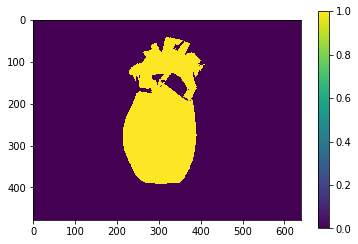

In [139]:
tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst,gt_est_mask,picked_tiles = greedy(sample,28,"","ground_truth")

plt.imshow(gt_est_mask)
plt.colorbar()

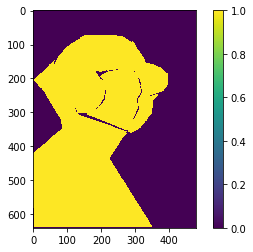

In [136]:
tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst,gt_est_mask,picked_tiles = greedy(sample,34,"","ground_truth")

plt.imshow(gt_est_mask)
plt.colorbar()

In [112]:
sample = "25workers_rand0"
objid=3
for objid in [38,29,2,17,22,31]:
    p,r,j = greedy(sample,objid,"","ground_truth")
    #tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst = greedy(sample,objid,"","ground_truth")
    print sample,objid,p,r,j

here
4373.0 37505.0
0.116597786962
25workers_rand0 38 0.998346269771 0.997654396674 0.996008408952
here
1491.0 6901.0
0.21605564411
25workers_rand0 29 0.976860448507 0.991015794812 0.96828543112
here
6432.0 6659.0
0.965910797417
25workers_rand0 2 0.999849170437 0.995494819042 0.995345345345
here
572.0 2327.0
0.245810055866
25workers_rand0 17 0.994285714286 0.972067039106 0.966666666667
here
631.0 1261.0
0.500396510706
25workers_rand0 22 0.98834304746 0.941316415543 0.930980392157
here
2321.0 25519.0
0.0909518398056
25workers_rand0 31 0.992871969608 0.992988640815 0.985959863099


In [100]:
sample = "25workers_rand0"
objid = 3
tiles,srt_decr_idx,ia_lst,candidate_tile_lst, jaccard_lst,gt_est_mask,picked_tiles = greedy(sample,objid,"","ground_truth")

969.0 969.0
-10000.0


In [92]:
np.array(ia_lst)[srt_decr_idx][0]

2691.0

In [87]:
srt_decr_idx

array([256, 254,  14,  89,  28, 163, 235, 214,  72,  30,   3, 133, 247,
        27,  43,  82, 157,  12, 246, 197,  47, 253,  85,  86,  87,  68,
        88,  90,  69,  70,  84,  83,  71,  80,  79,  91,  78,  77,  76,
        75,  74,  73,  81,  97,  92,  93, 120, 119, 118, 117, 116, 115,
       114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102,
       101, 100,  99,  98,  66,  96,  95,  94,  67,  58,  65,  17,  32,
        31,  29,  26,  25,  24,  23,  22,  21,  20,  19,  18,  16,  64,
        15,  13,  11,  10,   9,   8,   7,   6,   5,   4,   2,   1,  33,
        34,  35,  36,  63,  62,  61,  60,  59, 122,  57,  56,  55,  54,
        53,  52,  51,  50,  49,  48,  46,  45,  44,  42,  41,  40,  39,
        38,  37, 121, 128, 123, 220, 218, 217, 216, 215, 213, 212, 211,
       210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198,
       196, 195, 194, 193, 192, 191, 190, 219, 221, 188, 222, 252, 251,
       250, 249, 248, 245, 244, 243, 242, 241, 240, 239, 238, 23

In [88]:
len(candidate_tile_lst)

257

In [85]:
[tiles.index(t) for t in candidate_tile_lst]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 46,
 49,
 50,
 52,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 94,
 95,
 96,
 97,
 99,
 101,
 103,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 117,
 118,
 119,
 122,
 124,
 126,
 127,
 128,
 129,
 131,
 137,
 138,
 143,
 145,
 146,
 148,
 149,
 152,
 154,
 155,
 156,
 161,
 163,
 169,
 172,
 173,
 174,
 175,
 178,
 179,
 180,
 182,
 184,
 191,
 193,
 196,
 198,
 201,
 202,
 203,
 208,
 212,
 214,
 217,
 218,
 219,
 220,
 221,
 223,
 225,
 226,
 227,
 230,
 233,
 234,
 236,
 240,
 243,
 246,
 253,
 256,
 258,
 264,
 265,
 268,
 269,
 271,
 272,
 273,
 282,
 283,
 284,
 288,
 297,
 305,
 307,
 308,
 309,
 311,
 318,
 319,
 321,
 323,
 325,
 327,
 333,
 336,
 338,
 342

In [74]:
tarea = np.array([len(t) for t in tiles])
tarea[np.argsort(tarea)[::-1]]
print np.argsort(tarea)[::-1]

[  0 656 643 649 652 585   2  86  42  41 645 362  94 155 613   7   5  18
  50 483  43  84  89 534 647 560  30  87  14 648 309 505  32  58 567  96
   1 457 644 319 610 124 103 214 386 136 531 294 564 557  49  10 578  54
  17 609  22 274 480  74 428 611   3 308 297 170   4 129 646 441 270 617
 533 191 111  64 208 119 485 321 337 268 506 292  91 590 410 507 326 535
  73 263 539 526 558 283  69 453 339 113 586 370 626 622 481 167 158 604
 403 527 338 437  33 476 474 427  45  46 516 528 461 109 104 112 115 466
 114 310 484 459 458 152 408 404 205 350 164 394 390 198 197 192 181 374
 187 183 371 409 413 120 211 121 320 125 322 127 130 324 438 653 435 655
 432 140 141 215 433 366 545 250  44 565  47  48 556 608 553 572  53 612
  55  57  59  28 571 574 247 275  29 594  31  27 591 589 584 576  26  35
  24 603 605 606  61 597 630   6 509 634  21  85 186  12 628 513 266  88
 518  75 233 638 624 493  19 641 537 491 188 207 206 261 199 189 204 203
 202 201 190 193 194 257 195 196 260 259 258 200 22

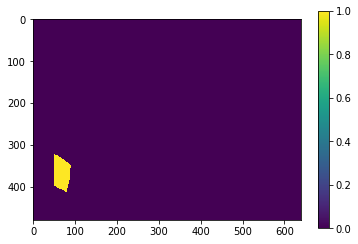

In [101]:
plot_tile(objid,tiles[656])

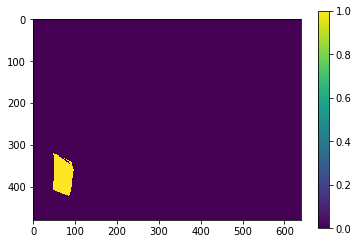

In [102]:
plt.imshow(gt_est_mask)
plt.colorbar()

In [8]:
ia_lst[srt_decr_idx[22]]

0.0

In [9]:
len(tiles[srt_decr_idx[22]])

2

In [10]:
def plot_tile(objid,tile):
    gt = get_gt_mask(objid)
    img = np.zeros_like(gt)
    for tidx in tile:
        img[tidx]=1
    plt.imshow(img)
    plt.colorbar()

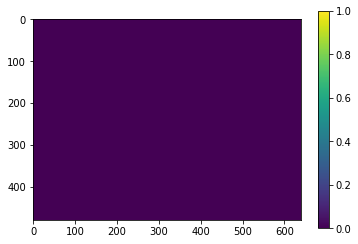

In [11]:
plot_tile(objid,tiles[srt_decr_idx[22]])

In [12]:
ia_lst[22]

0.0

In [13]:
candidate_tile_lst[22]

{(416, 89), (417, 89)}

In [14]:
jaccard_lst[22]

0.9989690721649485

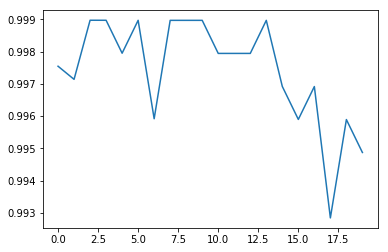

In [25]:
plt.plot(jaccard_lst[:20])

In [16]:
# plt.imshow(mask)
# plt.colorbar()

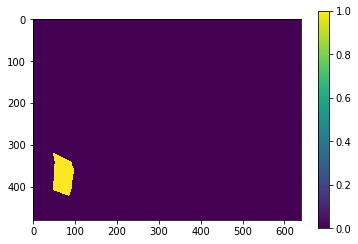

In [17]:
gt = get_gt_mask(objid)
plt.imshow(gt)
plt.colorbar()